MixUp 可视化 (随机选择5个样本)


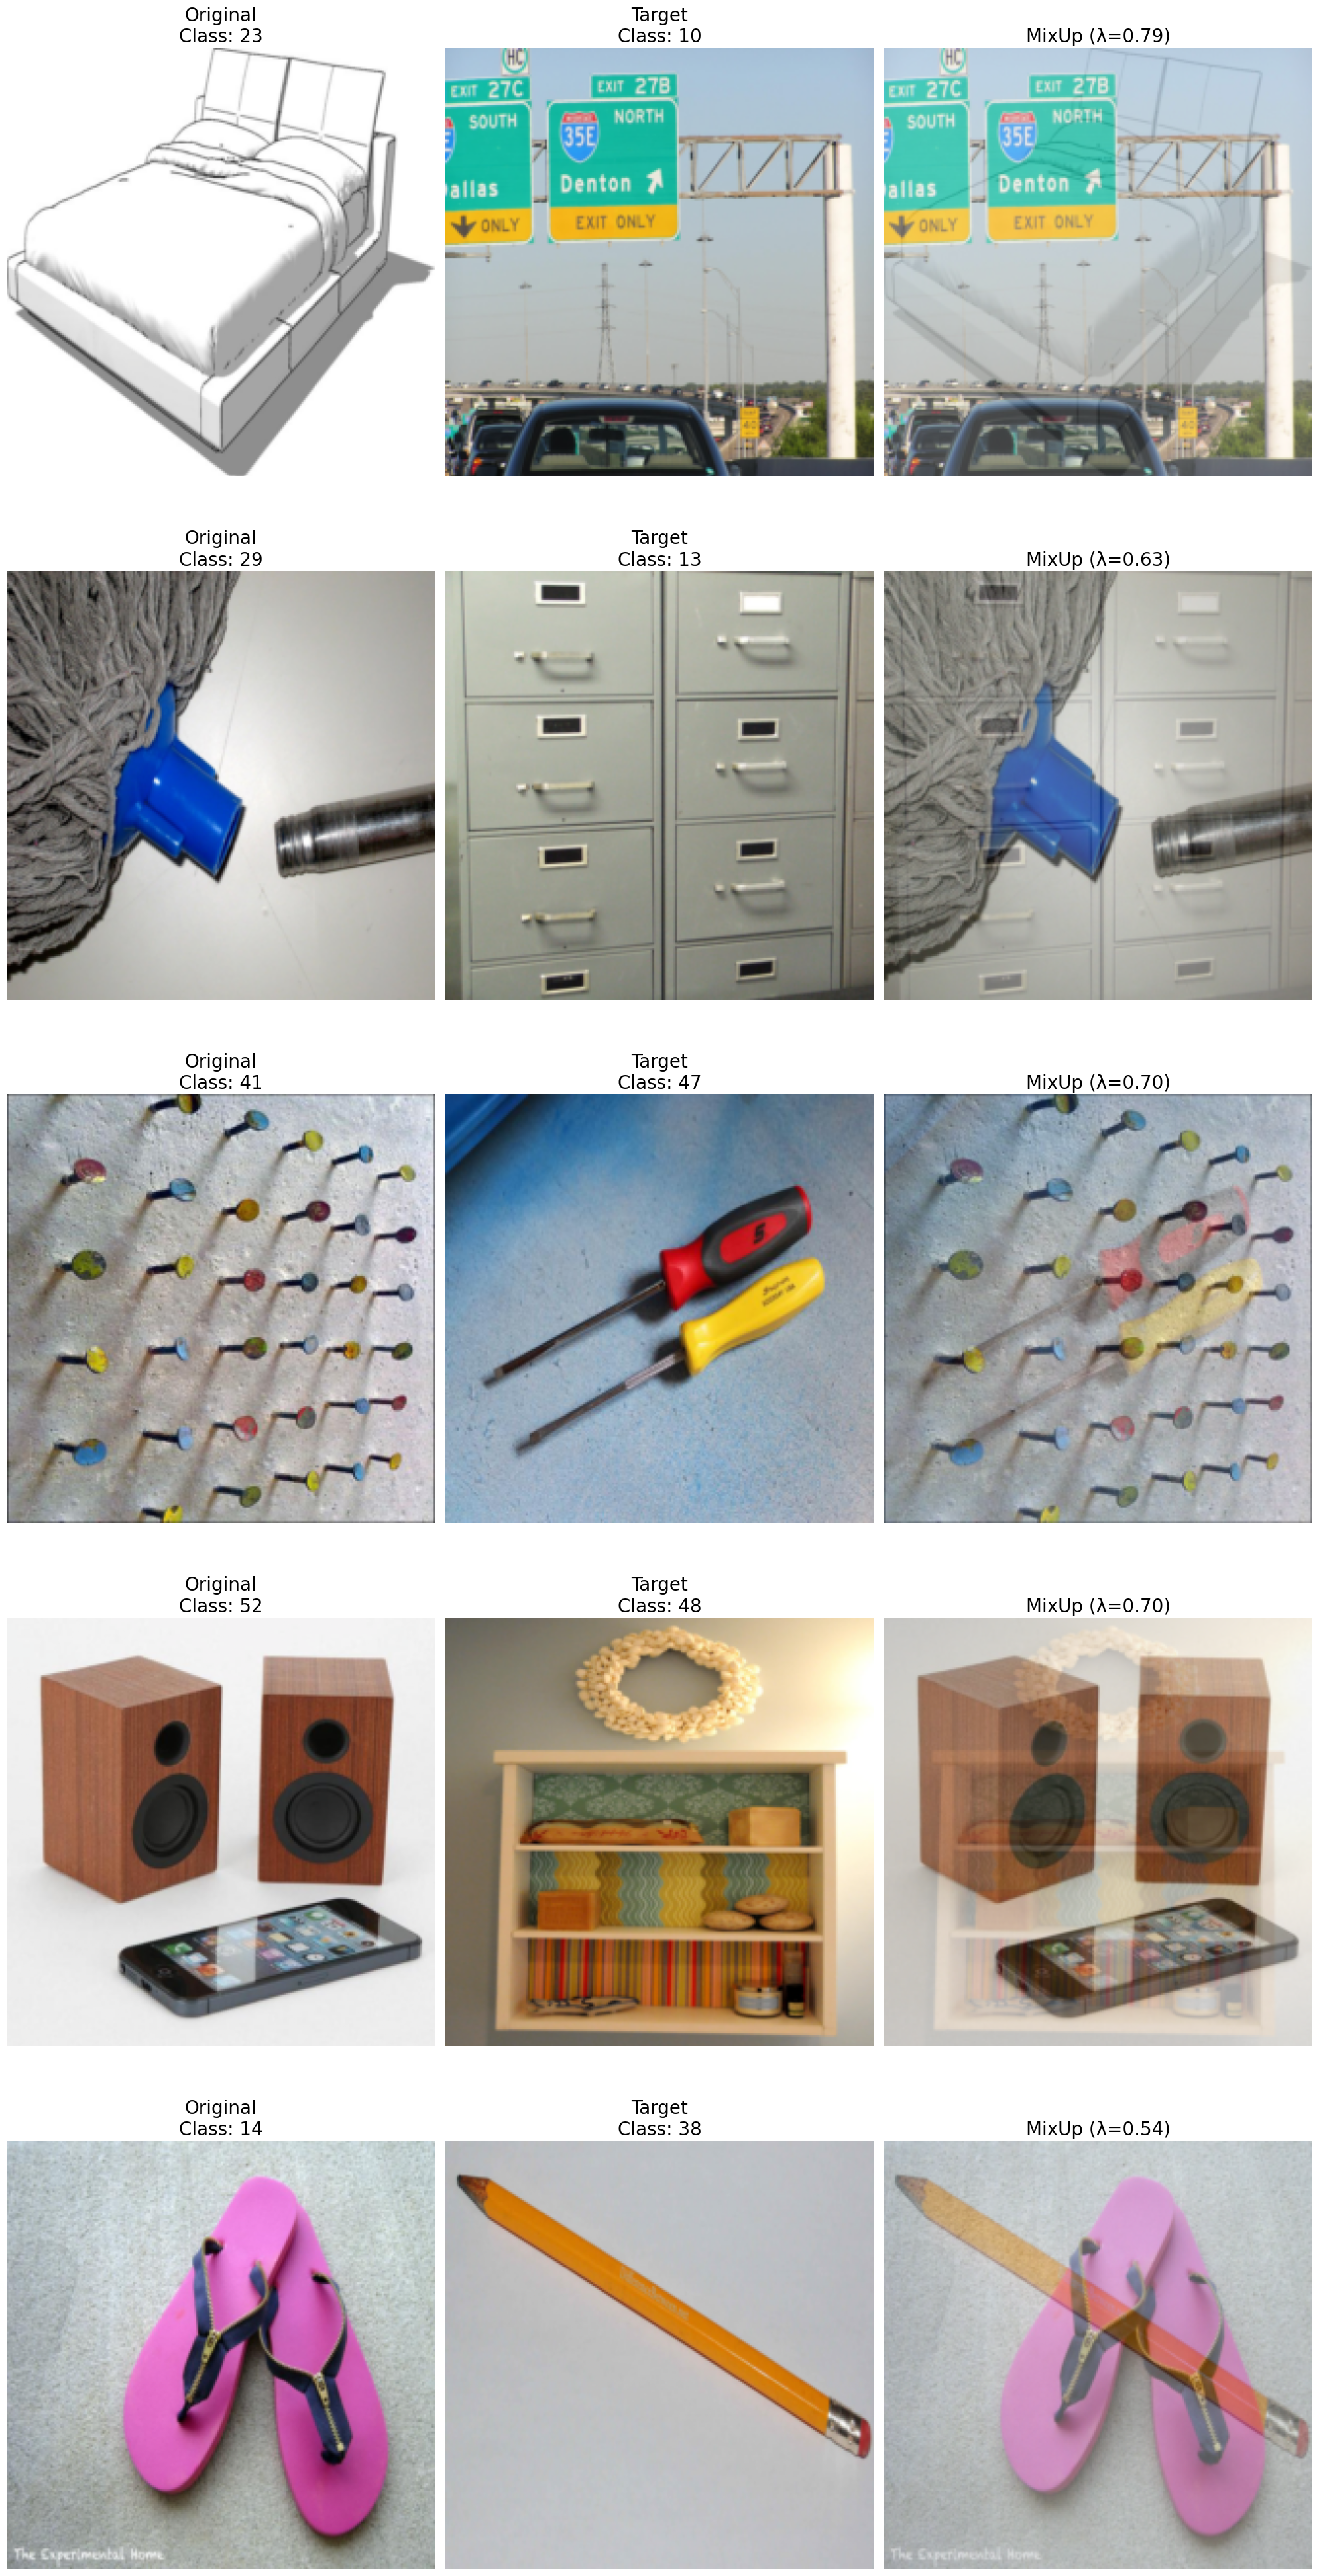

In [34]:
import os
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 数据集路径配置
DATA_PATH = "/root/autodl-tmp/Real World"
NUM_CLASSES = 65
IMAGE_SIZE = 224

# 自定义数据集类
class ClassBalancedDataset(Dataset):
    def __init__(self, root_dir, num_classes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.samples = self._load_one_sample_per_class()
        
    def _load_one_sample_per_class(self):
        samples = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
                
            images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if not images:
                continue
                
            selected_image = random.choice(images)
            samples.append((os.path.join(class_dir, selected_image), class_idx))
            
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

# 定义图像变换
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
dataset = ClassBalancedDataset(DATA_PATH, NUM_CLASSES, transform=transform)
dataloader = DataLoader(dataset, batch_size=NUM_CLASSES, shuffle=True)
images, labels = next(iter(dataloader))

# MixUp和CutMix实现
class MixupCutmixGenerator:
    def __init__(self, alpha=1.0, cutmix_prob=0.5, num_classes=65):
        self.alpha = alpha
        self.cutmix_prob = cutmix_prob
        self.num_classes = num_classes
        self.indices = None
        self.bboxes = []  # 保存每个样本的bbox
        
    def _rand_bbox(self, size, lam):
        W, H = size[3], size[2]  # 注意尺寸顺序: (C, H, W)
        cut_rat = np.sqrt(1. - lam)
        cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
        
        # 确保中心点均匀分布
        cx = int(np.random.uniform(0.2, 0.8) * W)
        cy = int(np.random.uniform(0.2, 0.8) * H)
        
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        return bbx1, bby1, bbx2, bby2
    
    def generate(self, images, labels):
        self.bboxes = []  # 清空之前的bbox
        self.indices = torch.randperm(images.size(0), device=images.device)
        shuffled_images = images[self.indices]
        shuffled_labels = labels[self.indices]
        
        mixed_images = images.clone()
        mixed_labels = torch.zeros(len(images), self.num_classes, 
                                 device=images.device, dtype=images.dtype)
        
        for i in range(len(images)):
            lam = max(0.2, min(0.7, np.random.beta(self.alpha, self.alpha)))
            
            if np.random.rand() < self.cutmix_prob:
                # CutMix
                bbx1, bby1, bbx2, bby2 = self._rand_bbox(images.size(), lam)
                mixed_images[i, :, bby1:bby2, bbx1:bbx2] = shuffled_images[i, :, bby1:bby2, bbx1:bbx2]
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size(2) * images.size(3)))
                self.bboxes.append((bbx1, bby1, bbx2, bby2))
            else:
                # MixUp
                mixed_images[i] = lam * images[i] + (1 - lam) * shuffled_images[i]
                self.bboxes.append(None)  # MixUp没有bbox
                
            # 混合标签 - 修正了数据类型问题
            lam_tensor = torch.tensor(lam, device=images.device)
            one_minus_lam = torch.tensor(1 - lam, device=images.device)
            
            # 创建one-hot标签
            target_labels = torch.zeros(self.num_classes, device=images.device)
            target_labels[labels[i]] = lam_tensor
            target_labels[shuffled_labels[i]] += one_minus_lam
            
            mixed_labels[i] = target_labels
            
        return mixed_images, mixed_labels

# 可视化函数
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def visualize_mixup_cutmix(images, labels, generator, num_examples=5):
    mixed_images, mixed_labels = generator.generate(images, labels)
    
    plt.figure(figsize=(20, 8*num_examples))
    gs = GridSpec(num_examples, 3, height_ratios=[1]*num_examples)
    
    for i in range(num_examples):
        # 原始图像1
        ax1 = plt.subplot(gs[i, 0])
        img1 = denormalize(images[i]).permute(1, 2, 0).numpy()
        ax1.imshow(np.clip(img1, 0, 1))
        ax1.set_title(f"Original\nClass: {labels[i].item()}", fontsize=20)
        ax1.axis('off')
        
        # 混合目标图像
        ax2 = plt.subplot(gs[i, 1])
        img2_idx = generator.indices[i].item()
        img2 = denormalize(images[img2_idx]).permute(1, 2, 0).numpy()
        ax2.imshow(np.clip(img2, 0, 1))
        ax2.set_title(f"Target\nClass: {labels[img2_idx].item()}", fontsize=20)
        ax2.axis('off')
        
        # 混合结果
        ax3 = plt.subplot(gs[i, 2])
        mixed_img = denormalize(mixed_images[i]).permute(1, 2, 0).numpy()
        lam = mixed_labels[i].max().item()
        
        if generator.cutmix_prob > 0.5 and generator.bboxes[i] is not None:
            # CutMix可视化
            ax3.imshow(np.clip(mixed_img, 0, 1))
            bbx1, bby1, bbx2, bby2 = generator.bboxes[i]
            rect = plt.Rectangle((bbx1, bby1), bbx2-bbx1, bby2-bby1,
                               fill=False, edgecolor='red', linewidth=2)
            ax3.add_patch(rect)
            title = f"CutMix (λ={lam:.2f})"
        else:
            # MixUp可视化
            ax3.imshow(np.clip(mixed_img, 0, 1))
            title = f"MixUp (λ={lam:.2f})"
        
        ax3.set_title(title, fontsize=20)
        ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化展示
print("="*50)
print("MixUp 可视化 (随机选择5个样本)")
mixup_generator = MixupCutmixGenerator(alpha=1.0, cutmix_prob=0.0)
visualize_mixup_cutmix(images, labels, mixup_generator, 5)

# print("="*50)
# print("CutMix 可视化 (随机选择5个样本)")
# cutmix_generator = MixupCutmixGenerator(alpha=1.0, cutmix_prob=1.0)
# visualize_mixup_cutmix(images, labels, cutmix_generator, 5)